In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
N_TOPICS = 30

STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0"])

<ipython-input-2-7b274af9ddda>:8: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [4]:
SCOL = "20000_90"
stormsDf[SCOL + "_storm"] = True

In [5]:
merged = pd.merge(artDf, stormsDf.drop(columns=[SCOL]), on="key", how="left")

In [161]:
#important: remove any dates before our first local date 
merged = merged[merged["date"] >= "2020-04-01"]


In [8]:
#load in our topics 
cols = ["dummy", "key"] + list(range(0, N_TOPICS))
docTopics = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/30/doc_topics.txt", sep="\t", names=cols)

#load in the words associated with topics 
topicWords = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/30/topic_keys.txt", sep="\t", \
                         names=["topicNum", "dummy", "words"], usecols=["topicNum", "words"])

merged = pd.merge(merged, docTopics.drop(columns=["dummy"]), on="key", how="left")

In [9]:
#quick check - largest storms have around 1000 articles 
stormSizes = merged.loc[merged[SCOL + "_storm"] == True, [SCOL, "key"]].groupby(SCOL).agg(len)

In [ ]:
def getMax(inRow): 
    maxT = None 
    maxVal = 0
    for i in range(0, len(inRow)): 
        currVal = inRow[i]
        if currVal >= maxVal: 
            maxVal = currVal 
            maxT = i 
    return maxT

In [63]:
#get only rows associated with storms 
stormRows = merged.loc[merged[SCOL + "_storm"] == True]

#stormTopics = pd.DataFrame(stormRows[list(range(0, N_TOPICS))].apply(sum)).reset_index().rename(columns={"index":"topicNum", 0:"topicAmt"})

stormTopics = pd.DataFrame(stormRows[list(range(0, N_TOPICS))]).idxmax(axis=1).value_counts().reset_index().rename(columns={"index":"topicNum", "count":"topicAmt"})
stormTopics["topicNum"] = stormTopics["topicNum"].astype(int)

stormTopics  = pd.merge(stormTopics , topicWords, on="topicNum")
stormTopics ["firstWords"] = stormTopics ["words"].apply(lambda x: ",".join(x.split()[:3]))

stormTopics["amtNormed"] = (stormTopics["topicAmt"] / sum(stormTopics["topicAmt"]))* 100
stormTopics  = stormTopics.sort_values("amtNormed", ascending=False)

In [64]:
stormTopics.head()

,topicNum,topicAmt,words,firstWords,amtNormed
0,11,2796,court case law judge attorney justice federal ...,"court,case,law",13.752398
1,6,2492,police officers man officer city people black ...,"police,officers,man",12.257144
2,1,2408,bill state house senate democrats federal law ...,"bill,state,house",11.843982
3,3,2218,election state voters vote party voting republ...,"election,state,voters",10.909449
4,19,1967,trump president house capitol committee u.s fb...,"trump,president,house",9.674881


In [56]:
#.astype(int).value_counts().reset_index().rename(columns={0:"topicNum", "count":"topicAmt"})

In [58]:
nonStormTopics["topicNum"] = nonStormTopics["topicNum"].astype(int)

In [67]:
#get only rows NOT associated with storms 
nonStormRows = merged.loc[merged[SCOL + "_storm"] != True]

#nonStormTopics = pd.DataFrame(nonStormRows[list(range(0, N_TOPICS))].dropna().apply(sum)).reset_index().rename(columns={"index":"topicNum", 0:"topicAmt"})
nonStormTopics = pd.DataFrame(nonStormRows[list(range(0, N_TOPICS))]).idxmax(axis=1).value_counts().reset_index().rename(columns={"index":"topicNum", "count":"topicAmt"})
nonStormTopics["topicNum"] = nonStormTopics["topicNum"].astype(int)

nonStormTopics  = pd.merge(nonStormTopics, topicWords, on="topicNum")
nonStormTopics["firstWords"] = nonStormTopics["words"].apply(lambda x: ",".join(x.split()[:3]))

nonStormTopics["amtNormed"] = (nonStormTopics["topicAmt"] / sum(nonStormTopics["topicAmt"])) * 100
nonStormTopics  = nonStormTopics.sort_values("amtNormed", ascending=False)

In [62]:
#sanity check: sum(nonStormTopics["amtNormed"])

In [151]:
#figure stuff
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = [ "#008837", "#7b3294"]

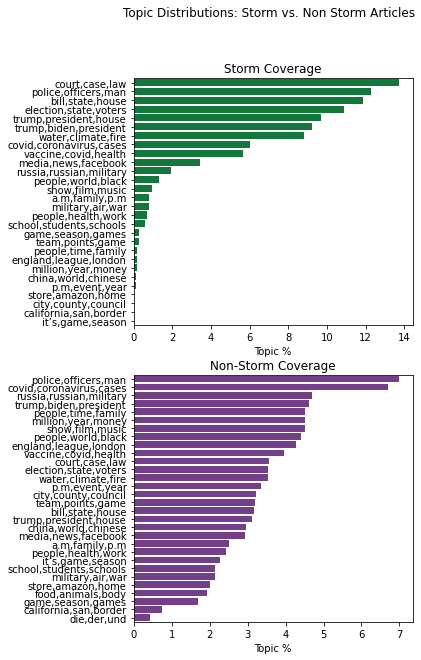

In [158]:
fig, axs = plt.subplots(2, figsize=(5, 10))
sns.barplot(x="amtNormed", y="firstWords",data=stormTopics, ax=axs[0], palette = [PALETTE[0]])
sns.barplot(x="amtNormed", y="firstWords",data=nonStormTopics, ax=axs[1], palette = [PALETTE[1]])

plt.suptitle("Topic Distributions: Storm vs. Non Storm Articles")
axs[0].set_title("Storm Coverage")
axs[1].set_title("Non-Storm Coverage")
axs[0].set_ylabel(None)
axs[1].set_ylabel(None)

axs[0].set_xlabel("Topic %")
axs[1].set_xlabel("Topic %")

plt.savefig(FIG_PATH + "stormTopicDists.pdf", bbox_inches = "tight")

In [98]:
bothTopics = pd.merge(stormTopics[["topicNum", "amtNormed", "firstWords"]].rename(columns={"amtNormed":"stormAmtNormed"}), \
                                                                             nonStormTopics[["topicNum", "amtNormed"]].rename(columns={"amtNormed":"nonStormAmtNormed"}), on="topicNum", how="inner")

In [99]:
bothTopics["diff"] = bothTopics["stormAmtNormed"] - bothTopics["nonStormAmtNormed"]
bothTopics = bothTopics.sort_values("diff", ascending=False)

In [102]:
bothTopics["pos"] = bothTopics["diff"] >= 0 

<ipython-input-150-8abda5e8cc84>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


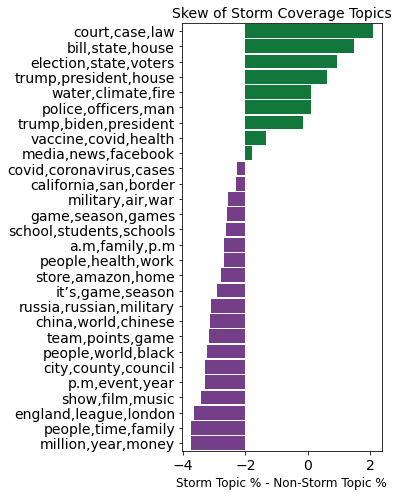

In [150]:

colDict = {True:PALETTE[0], False:PALETTE[1]}

fig, ax = plt.subplots(1, figsize=(5.5, 7))
plot = sns.barplot(x="diff", y="firstWords", palette= [colDict[item] for item in bothTopics["pos"]] ,data=bothTopics, width=.9,ax=ax)
ax.set_ylabel(None)
ax.set_xlabel("Storm Topic % - Non-Storm Topic %",fontsize=12)
#ax.set_title("Skew of Storm Coverage Topics", fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.tight_layout()
plt.savefig(FIG_PATH + "stormTopicDiffs.pdf")

In [122]:
#we should also check by taking each clusters average topic distribution 
stormClusts = merged.loc[merged[SCOL + "_storm"] == True, [SCOL] + list(range(0, 30))].groupby(SCOL).agg(np.mean)

In [127]:
stormCTopics = stormClusts.apply(sum).reset_index().rename(columns={"index":"topicNum", 0:"topicAmt"})
stormCTopics  = pd.merge(stormCTopics , topicWords, on="topicNum")
stormCTopics ["firstWords"] = stormCTopics ["words"].apply(lambda x: ",".join(x.split()[:3]))

stormCTopics["amtNormed"] = stormCTopics["topicAmt"] / sum(stormCTopics["topicAmt"])
stormCTopics  = stormCTopics .sort_values("amtNormed", ascending=False)

In [130]:
#we should also check by taking each clusters average topic distribution 
nonStormClusts = merged.loc[merged[SCOL + "_storm"] != True, [SCOL] + list(range(0, 30))].groupby(SCOL).agg(np.mean)

In [133]:
nonStormCTopics = nonStormClusts.apply(sum).reset_index().rename(columns={"index":"topicNum", 0:"topicAmt"})
nonStormCTopics  = pd.merge(nonStormCTopics , topicWords, on="topicNum")
nonStormCTopics ["firstWords"] = nonStormCTopics ["words"].apply(lambda x: ",".join(x.split()[:3]))

nonStormCTopics["amtNormed"] = nonStormCTopics["topicAmt"] / sum(nonStormCTopics["topicAmt"])
nonStormCTopics  = nonStormCTopics .sort_values("amtNormed", ascending=False)

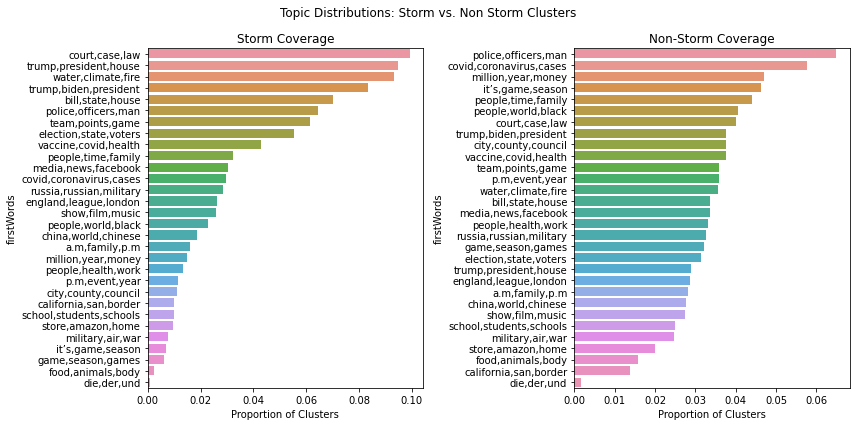

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x="amtNormed", y="firstWords",data=stormCTopics, ax=axs[0])
sns.barplot(x="amtNormed", y="firstWords",data=nonStormCTopics, ax=axs[1])

plt.suptitle("Topic Distributions: Storm vs. Non Storm Clusters")

axs[0].set_xlabel("Proportion of Clusters")
axs[0].set_title("Storm Coverage")

axs[1].set_xlabel("Proportion of Clusters")
axs[1].set_title("Non-Storm Coverage")

plt.tight_layout()

In [121]:
#we should also check by taking each clusters average topic distribution 
nonStormClusts = merged.loc[merged[SCOL + "_storm"] != True, [SCOL] + list(range(0, 30))].groupby(SCOL).agg(np.mean)

In [116]:
numStorms = pd.DataFrame(merged.loc[merged[SCOL + "_storm"] == True, "source"].value_counts()).reset_index()

In [129]:
inStorms = list(numStorms.loc[numStorms["count"] >= 10, "source"])
mergedStorms = merged.loc[(merged["source"].isin(inStorms)) & (merged[SCOL + "_storm"] == True)]

In [133]:
def getPairs(inList):
    inList = list(set(inList))
    outList = []
    for i in range(len(inList)): 
        for j in range(i+1, len(inList)): 
            outList.append((inList[i], inList[j]))
    return outList 

stormSources = mergedStorms[[SCOL,"source"]].groupby(SCOL).agg(list)


In [134]:
stormSources["source"] = stormSources["source"].apply(getPairs)
stormSources = stormSources.explode("source")

In [135]:
stormSources[["lSource", "rSource"]] = stormSources["source"].tolist()
stormSources = stormSources.drop(columns=["source"])

In [136]:
stormSources = stormSources.T.transform(np.sort).T

In [137]:
stormSources["weight"] = 1
stormSources = stormSources.groupby(["lSource", "rSource"]).agg(sum).reset_index()

In [138]:
stormGraph = nx.from_pandas_edgelist(stormSources, source="lSource", target="rSource", edge_attr="weight")

In [143]:
comms = nx.community.louvain_communities(stormGraph, weight='weight', resolution=1, threshold=1e-07, seed=21)